# Statistics of NMRlipids databank

This notebook plots:
1. Distributions of simulation lengths, number of atoms and trajectory sizes
2. Distribution of number of lipid components
3. Available single component bilayers and binary lipid mixtures
4. Pie diagram of temperatures

# Initializing databank

In [1]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request
import yaml
import pandas as pd
import seaborn as sns
import collections


sys.path.insert(1, '../BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


# Plot distributions of simulation lengths, number of atoms and trajectory sizes

Number of entries:  554
Total size of trajectories:  1473.9746408024803 Gb
Total time of trajectories:  245407.70403053286 ns


Text(0, 0.5, 'Distribution')

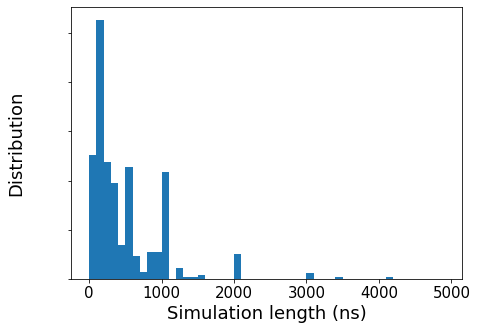

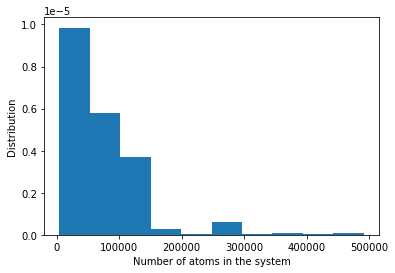

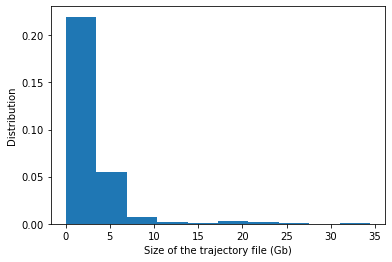

In [5]:
SimulationLengths = []
NumberOfAtoms = []
SizeOfTrajectories = []

# Loop over simulations in the Databank
for system in systems:
    SimulationLengths.append(system['TRJLENGTH']*0.001)
    NumberOfAtoms.append(system['NUMBER_OF_ATOMS'])
    SizeOfTrajectories.append(system['TRAJECTORY_SIZE']/(1024*1024*1024))
    
print("Number of entries: ",len(systems))
print("Total size of trajectories: ",str(np.sum(SizeOfTrajectories)) + ' Gb')
print("Total time of trajectories: ",str(np.sum(SimulationLengths)) + ' ns')

plt.figure(figsize=(7,5))
distSIMl = plt.hist(SimulationLengths, density=True,bins=np.arange(0,5000,100))
plt.xlabel('Simulation length (ns)', fontsize=18)
plt.ylabel('Distribution', fontsize=18)
plt.yticks(color='w')
plt.xticks(fontsize=15)
plt.savefig('../../../DataBankManuscriptText/Figures/LengthDist.pdf')
plt.figure()
distNatoms = plt.hist(NumberOfAtoms, density=True)
plt.xlabel('Number of atoms in the system')
plt.ylabel('Distribution')
plt.figure()
disttrjSIZE = plt.hist(SizeOfTrajectories, density=True)
plt.xlabel('Size of the trajectory file (Gb)')
plt.ylabel('Distribution')

# Plot distribution of number of lipid components

<Figure size 720x504 with 0 Axes>

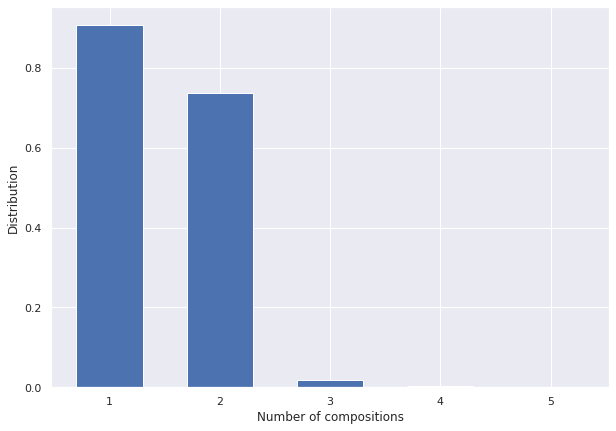

<Figure size 720x504 with 0 Axes>

In [37]:
Nlipids = []

# Loop over simulations in the Databank
for system in systems:
    NlipidsTMP = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NlipidsTMP += 1
    Nlipids.append(NlipidsTMP)
    
bins=[0.7,1.3, 1.7,2.3, 2.7,3.3, 3.7,4.3, 4.7, 5.3]
distNlipids = plt.hist(Nlipids, density=True, range=[0,6], bins=bins)
plt.xlabel('Number of compositions')
plt.ylabel('Distribution')
plt.figure()

# Plot available single component bilayers and binary lipid mixtures

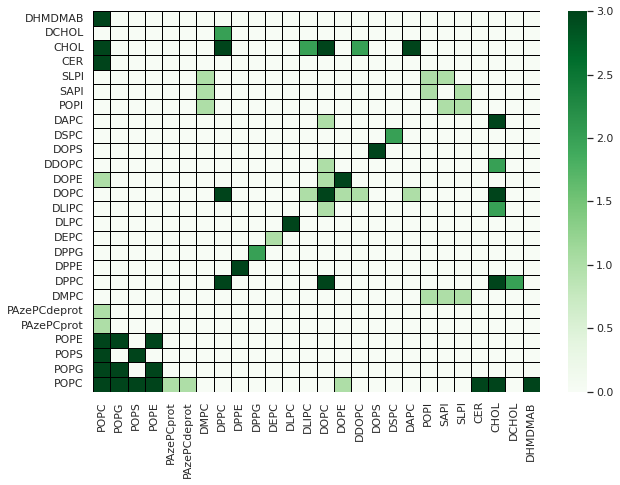

In [12]:
compositions = {}
for lipid in lipids_dict:
    compositions[lipid] = {}

for key in compositions:
    for lipid in lipids_dict:
        compositions[key][lipid] = 0


# Loop over simulations in the Databank
for system in systems:
    lipids_in_system = []
    for mol in system['COMPOSITION']:
        if mol in lipids_dict:
            lipids_in_system.append(mol)
    
    for lipid1 in lipids_in_system:
        for lipid2 in lipids_in_system:
            if lipid1 != lipid2:
                compositions[lipid1][lipid2] += 1
            #print(mol,system['COMPOSITION'][mol]['COUNT'])
            #compositions[mol] =
    
    if len(lipids_in_system) == 1:
        lipid = lipids_in_system[0]
        compositions[lipid][lipid] += 1

df = pd.DataFrame(compositions)
z=df.values

sns.set(rc = {'figure.figsize':(10,7)})
ax = sns.heatmap(df, cmap = 'Greens', vmin =0, vmax = 3, linewidths = 1, linecolor = 'black')
ax.invert_yaxis()
plt.savefig('../../../DataBankManuscriptText/Figures/systems.pdf')

# Plotting pie diagram of temperatures

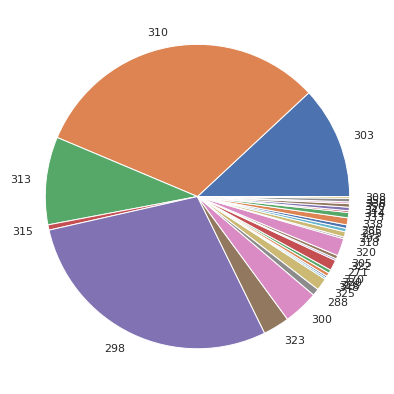

In [6]:
#db_data.pie_temperature()
import collections
temps = [ int(float(system['TEMPERATURE'])) for system in systems]
counter = collections.Counter(temps)
plt.pie(counter.values(),labels=counter.keys());

<Figure size 720x504 with 0 Axes>

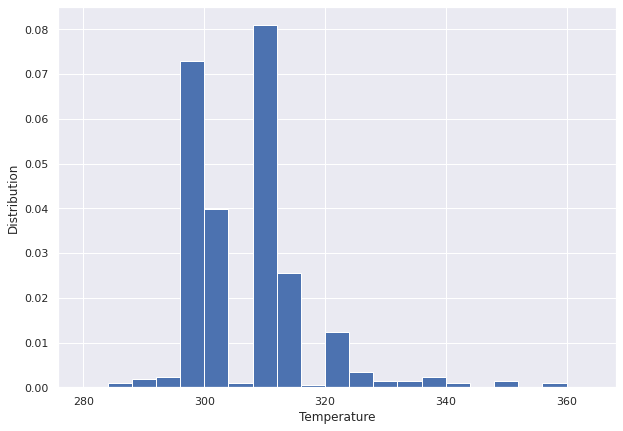

<Figure size 720x504 with 0 Axes>

In [7]:
distTemps = plt.hist(temps, density=True, bins=np.arange(280,365,4))
plt.xlabel('Temperature')
plt.ylabel('Distribution')
plt.figure()

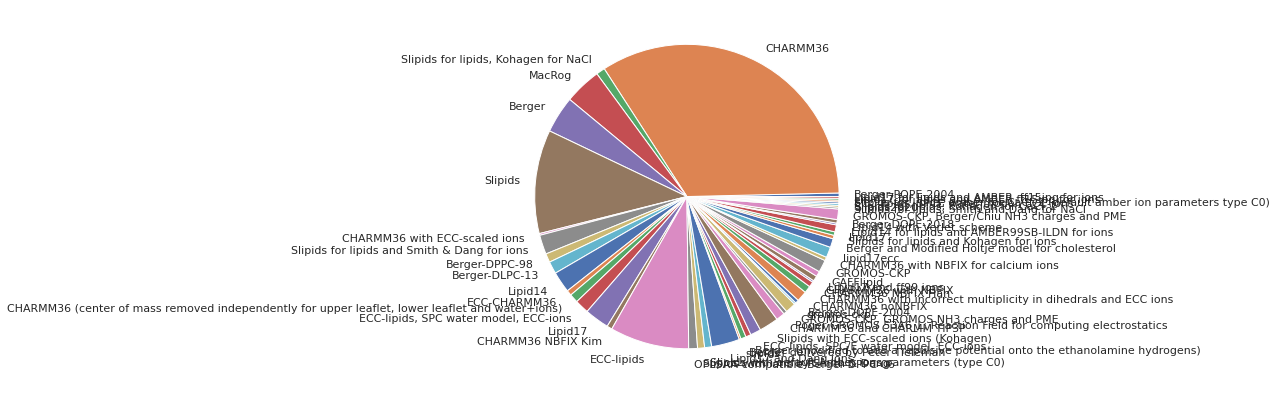

In [8]:

temps = [ system['FF'] for system in systems]
counter = collections.Counter(temps)
plt.pie(counter.values(),labels=counter.keys());

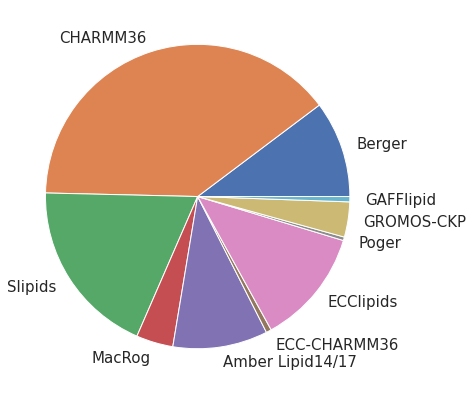

In [14]:
ffs = []

for system in systems:
    try:
        ff = system['FF']
    except:
        print('Force field information missing from' + system['path'])
    
    if 'GROMOS-CKP' in ff or 'gromos-ckp' in ff:
        ffs.append('GROMOS-CKP')
    elif 'Berger' in ff:
        ffs.append('Berger')    
    elif 'Slipids' in ff or 'slipids' in ff:
        ffs.append('Slipids')    
    elif 'lipid17ecc' in ff or 'ECC-lipids' in ff:
        ffs.append('ECClipids')
    elif 'ECC-CHARMM36' in ff:
        ffs.append(ff)
    elif 'CHARMM36' in ff:
        ffs.append('CHARMM36')
    elif 'Lipid14' in ff or 'Lipid17' in ff or 'lipid17' in ff:
        ffs.append('Amber Lipid14/17')
    elif 'Poger' in ff:
        ffs.append('Poger')
    else:
        ffs.append(ff)
    
counter = collections.Counter(ffs)
plt.pie(counter.values(),labels=counter.keys(), textprops={'fontsize': 15});
plt.savefig('../../../DataBankManuscriptText/Figures/FFpie.pdf')

In [49]:
for i in ffs:
    if 'gromos' in i:
        print(i)

gromos-ckp


{'DCHOL': 2, 'DDOPC': 2, 'CER': 5, 'DEPC': 1, 'DMPC': 1, 'SAPI': 1, 'POPI': 1, 'SLPI': 1, 'DLIPC': 2, 'PAzePCprot': 1, 'DSPC': 2, 'DPPG': 2, 'DPPE': 3, 'PAzePCdeprot': 1}


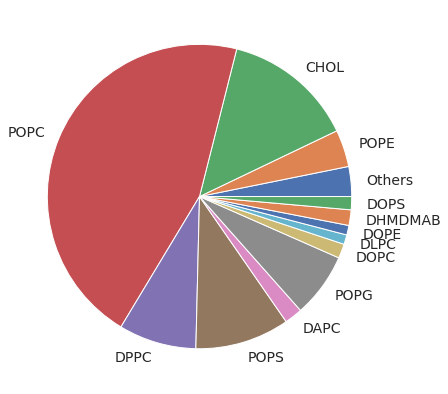

In [31]:
lipids = []
for system in systems:
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict:
            lipids.append(lipid)
counter = collections.Counter(lipids)
several = {}
several['Others'] = 0
less = {}
for i in counter:
    if counter[i] > 5:
        several[i] = counter[i]
    else:
        several['Others'] += counter[i] 
        less[i] = counter[i]
plt.pie(several.values(),labels=several.keys(), textprops={'fontsize': 14});
plt.savefig('../../../DataBankManuscriptText/Figures/FFlipids.pdf')
print(less)

In [139]:
def getTotalNlipids(system):
    NLIPIDS = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NLIPIDS += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return NLIPIDS

def getTotalNsolvent(system):
    NMOLECULES = 0
    for molecule in system['COMPOSITION']:
        if molecule not in lipids_dict:
            NMOLECULES += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return NMOLECULES

def checkAvailabilitySIM(system,lipid,counterion):
    status = {}
    TotalNlipids = getTotalNlipids(system)
    TotalNsolvent = getTotalNsolvent(system)
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    if counterion != 'no':
        try:
            Ncounterion = system['COMPOSITION'][counterion]['COUNT']
        except:
            Ncounterion = 0
    
    try:
        Nlipid = np.sum(system['COMPOSITION'][lipid]['COUNT'])
    except:
        Nlipid = 0
    
    path = system['path']
    
    QualityEvaluated = False
    TotalQualityFilePath = path + '/SYSTEM_quality.json'
    if (os.path.isfile(TotalQualityFilePath)):
        with open(TotalQualityFilePath) as json_file:
            Quality = json.load(json_file)
        json_file.close()
        if all(value > 0 for value in Quality.values()):
            #print(Quality)
            QualityEvaluated = True
            
    xrayQualityEvaluated = False
    xrayQualityFilePath = path + '/FormFactorQuality.json'
    if (os.path.isfile(xrayQualityFilePath)):
        with open(xrayQualityFilePath) as json_file:
            xrayQuality = json.load(json_file)
        json_file.close()
        if len(xrayQuality) > 0 and xrayQuality[0] > 0:
            xrayQualityEvaluated = True
    
    SingleComponentSystem = False
    if Nlipid == TotalNlipids:
        if counterion == 'no' and Nwater == TotalNsolvent:
            SingleComponentSystem = True
        if counterion != 'no'and  Nwater == TotalNsolvent-Ncounterion and Nlipid == Ncounterion:    
            SingleComponentSystem = True
        
    if SingleComponentSystem:
        status['Simulation'] = 'yes'
        status['FF'] = system['FF']
        if QualityEvaluated:
            status['Experiment'] = 'yes'
            status['Quality'] = Quality['total']
            
        if not QualityEvaluated:
            status['Experiment'] = 'no'
            status['Quality'] = 0 
            
        if xrayQualityEvaluated:
            status['xrayExperiment'] = 'yes'
            status['xrayQuality'] = xrayQuality[0]
            
        if not xrayQualityEvaluated:
            status['xrayExperiment'] = 'no'
            status['xrayQuality'] = 0 
                
    return status 
        
        
def giveStatus(systems,lipid,counterion):  
    status = {'Simulation': 'no', 'Experiment': 'no', 'Quality': 0, 'xrayExperiment': 'no', 'xrayQuality': 0}
    QualityEvaluatedFound = False
    for system in systems:
        TMPstatus = checkAvailabilitySIM(system,lipid,counterion)
        if TMPstatus and TMPstatus['Quality'] > status['Quality']:
            QualityEvaluatedFound = True
            status = TMPstatus 
        if TMPstatus and not QualityEvaluatedFound and TMPstatus['Simulation'] == 'yes':
            status = TMPstatus
    return status
    
def giveExpStatus(lipids,counterion,status):

    

    return status


    
HGs = {'PC', 'PE', 'PG', 'PS'}
tails = {'PO', 'DO', 'DP'}
table = {}

for tail in tails:
    table[tail] = {}
    for HG in HGs:
        lipid = tail + HG
        
        if lipid == 'POPS' or lipid == 'POPG' or lipid == 'DPPG':
            counterion = 'SOD'
        else:
            counterion = 'no'
        
        status = giveStatus(systems,lipid,counterion)
        statusString = ''
            
        if status['Quality'] > 0:
            if 'ECC-lipids' in status['FF']:
                FF = 'ECClipids'
            else:
                FF = status['FF']
            #print(status['xrayQuality'])
            statusString = FF + '(' + str(round(status['Quality'],2)) + ',' + str(round(status['xrayQuality'])) + ')'
        else:
            if status['Simulation'] == 'no':
                statusString = statusString + 'MD,'
            if status['Experiment'] == 'no':
                statusString = statusString + 'NMR,'
            if status['xrayExperiment'] == 'no':
                statusString = statusString + 'x-ray'
            
        table[tail][HG] = statusString

In [140]:
print(pd.DataFrame(table))
display(pd.DataFrame(table))

              DO                  PO            DP
PE  MD,NMR,x-ray   Slipids(0.52,122)     NMR,x-ray
PC     NMR,x-ray   Slipids(0.76,515)          NMR,
PS  MD,NMR,x-ray  ECClipids(0.5,297)  MD,NMR,x-ray
PG  MD,NMR,x-ray     Slipids(0.23,0)     NMR,x-ray


,DO,PO,DP
PE,"MD,NMR,x-ray","Slipids(0.52,122)","NMR,x-ray"
PC,"NMR,x-ray","Slipids(0.76,515)","NMR,"
PS,"MD,NMR,x-ray","ECClipids(0.5,297)","MD,NMR,x-ray"
PG,"MD,NMR,x-ray","Slipids(0.23,0)","NMR,x-ray"


In [103]:
print(pd.DataFrame(table))
display(pd.DataFrame(table))

    DO              PO  DP
PE   0   Slipids(0.52)   0
PC   0   Slipids(0.76)   0
PS   0  ECClipids(0.5)   0
PG   0   Slipids(0.23)   0


,DO,PO,DP
PE,0,Slipids(0.52),0
PC,0,Slipids(0.76),0
PS,0,ECClipids(0.5),0
PG,0,Slipids(0.23),0


In [121]:
status['xrayQuality']

0